In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
import matplotlib.pyplot as plt

# Dataset

In [4]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [5]:
#load the dataset
n_batch = 128
train_ds, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)
train = iter(train_ds)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-03-17 15:34:33.321535: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [7]:
def mlp(x, 
           vsa_dimension: int = 1024,
           spiking: bool = False,
           **kwargs):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    if spiking:
        x = phase_to_train(x)
    
    x = conv_1d(128)(x, spiking=spiking)
    x = conv_1d(10)(x,  spiking=spiking)

    if spiking: 
        x = train_to_phase(x, offset=0.25)
     
    return x

In [8]:
#declare the model as a transformation
model = hk.transform(mlp)

In [9]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [10]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, x_train[0:10,...])

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [11]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [12]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


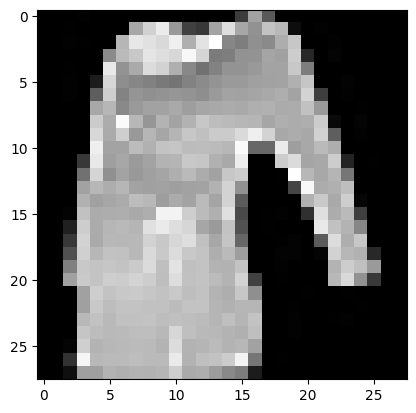

In [13]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

Text(0, 0.5, 'Density')

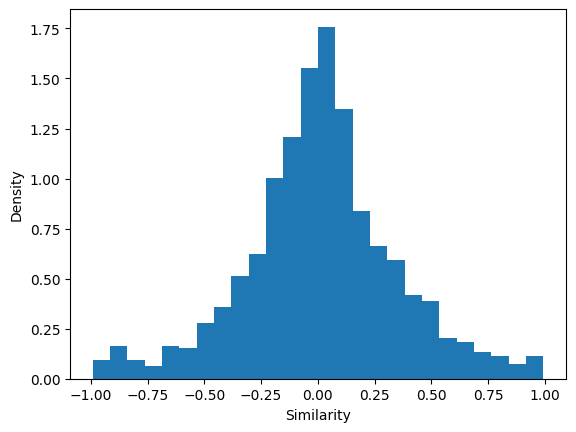

In [14]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred = model.apply(params, key, x)

plt.hist(np.array(pred.ravel()), bins=26, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

Text(0.5, 1.0, 'Pre-Train Similarity')

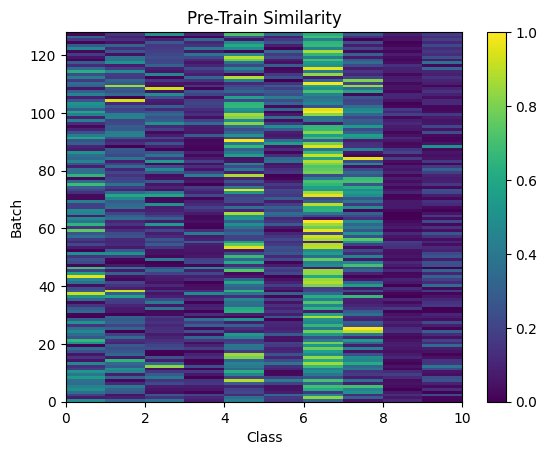

In [15]:
#Visualize the similarity each sample produces to the class codebook
plt.pcolor(jnp.abs(pred), vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Pre-Train Similarity")

In [16]:
loss_fn = lambda yh, y: quadrature_loss(yh, y, num_classes=10)

In [17]:
# Compute a sample of the loss function over these similarities. 
# Takes the complement of the similarity for the correct class label.
# This value (distance) will be minimized over training.

jnp.mean(loss_fn(pred, y))

DeviceArray(0.4549652, dtype=float32)

# Training

In [18]:
params_t, losses = train_model(model, 
                               key, 
                               params = params, 
                               dataset = train, 
                               optimizer = opt, 
                               loss_fn = loss_fn, 
                               batches = 1000)

100%|██████████| 1000/1000 [00:30<00:00, 32.36it/s]


Text(0, 0.5, 'Loss')

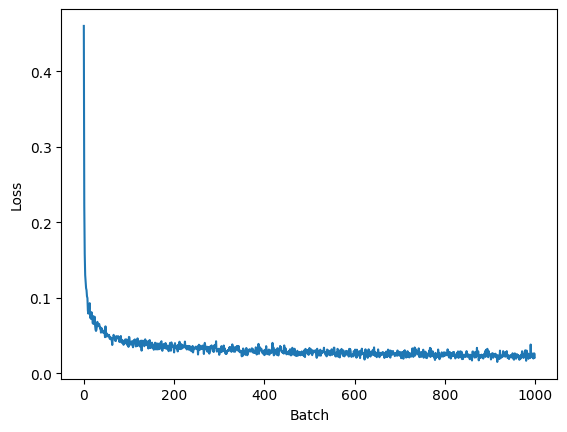

In [19]:
#Plot the history of the loss values over batches
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

# Test

In [20]:
#Load the testing dataset
test_ds, x_test, y_test = load_dataset(dataset, split="test", is_training=False, repeat = False, batch_size=n_batch)
test = iter(test_ds)

In [21]:
#Load a non-repeating copy of the training dataset
train2 = iter(load_dataset(dataset, split="train", is_training=False, repeat = False, batch_size=n_batch)[0])

In [22]:
#define a labmda to compute accuracy we can dispatch over batches
acc_fn = lambda b: accuracy_quadrature(model, key, params_t, b['image'], b['label'])
acc_fn_spk = lambda b: accuracy_quadrature(model, key, params_t, b['image'], b['label'], spiking=True)

In [23]:
#compute the test set accuracy
preds = jnp.concatenate([acc_fn(b) for b in test])
print("Test set accuracy is ", jnp.mean(preds))

Test set accuracy is  0.85469997


In [24]:
#compute train set accuracy
preds_t = jnp.concatenate([acc_fn(b) for b in train2])
print("Train set accuracy is ", jnp.mean(preds_t))

Train set accuracy is  0.89565


Text(0.5, 1.0, 'Post-Train Phases')

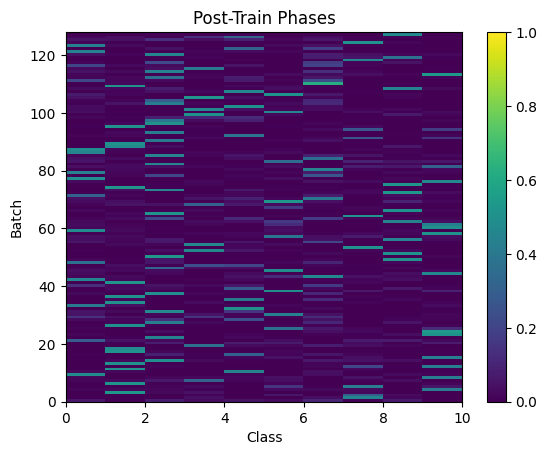

In [25]:
#Visualize the similarity each sample produces to the class codebook
sim2 = model.apply(params_t, key, x)

plt.pcolor(sim2, vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Post-Train Phases")

In [26]:
accs = accuracy_quadrature(model, key, params_t, x, y, spiking=True)
spiking_acc = jnp.mean(accs, axis=1)

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 533.83it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 3679.40it/s]


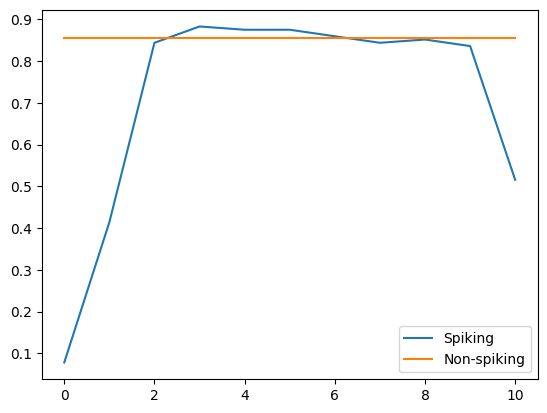

In [27]:
plt.plot(spiking_acc, label="Spiking")
plt.plot(jnp.ones_like(spiking_acc)* jnp.mean(preds), label="Non-spiking")
plt.legend()